In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

from utils import NMF, plot_nmf_components, plot_reconstructed_images

In [2]:
n = 100 # n samples
m = 25 # m features
r = 20

np.random.seed(0)
X = np.abs(np.random.randn(n,m))

# Apply NMF
model = NMF(n_components=r, max_iter=1000, random_state=42, verbose=True)
W = model.fit_transform(X)
H = model.H

# Check reconstruction
X_reconstructed = model.inverse_transform() # W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"\nFinal reconstruction error: {error:.4f}")

Iteration 100/1000, error: 11.7286
Iteration 200/1000, error: 10.7836
Iteration 300/1000, error: 10.4503
Iteration 400/1000, error: 10.2828
Iteration 500/1000, error: 10.2079
Iteration 600/1000, error: 10.1766
Iteration 700/1000, error: 10.1583
Iteration 800/1000, error: 10.1445
Iteration 900/1000, error: 10.1375
Iteration 1000/1000, error: 10.1333

Final reconstruction error: 10.1333


## NMS for Facial Feature Extraction

In [3]:
# Load LFW dataset
faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
images = faces.images  # shape (n_samples, height, width)

h, w = images.shape[1:]
X = faces.data.T  # shape (n_features, n_samples)

print(f"Images shape: (h,w)=({h},{w})")
print(f"Dataset shape: (n,m)={X.shape}")

Images shape: (h,w)=(50,37)
Dataset shape: (n,m)=(1850, 1288)


In [ ]:
r = 150

model = NMF(
    n_components=r,
    max_iter=2000,
    random_state=42,
    verbose=True
)
W = model.fit_transform(X)
H = model.H

# Check reconstruction
X_reconstructed = model.inverse_transform() # W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"\nFinal reconstruction error: {error:.4f}")

Iteration 100/1000, error: 117.2164
Iteration 200/1000, error: 89.5680
Iteration 300/1000, error: 78.5849
Iteration 400/1000, error: 72.9036
Iteration 500/1000, error: 69.5008
Iteration 600/1000, error: 67.2610
Iteration 700/1000, error: 65.6865
Iteration 800/1000, error: 64.5209
Iteration 900/1000, error: 63.6221
Iteration 1000/1000, error: 62.9084

Final reconstruction error: 62.9084


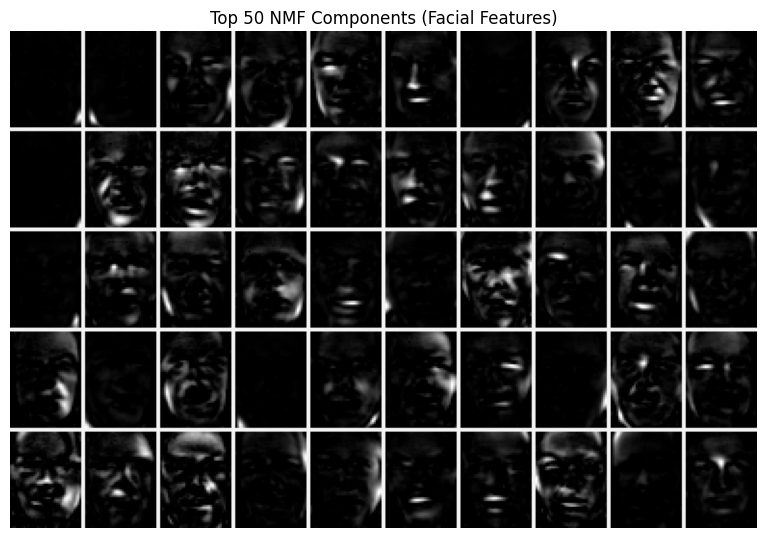

In [ ]:
plot_nmf_components(
    W, image_shape=(50, 37), 
    n_components=50, n_cols=10, 
    title="Some NMF Components"
)

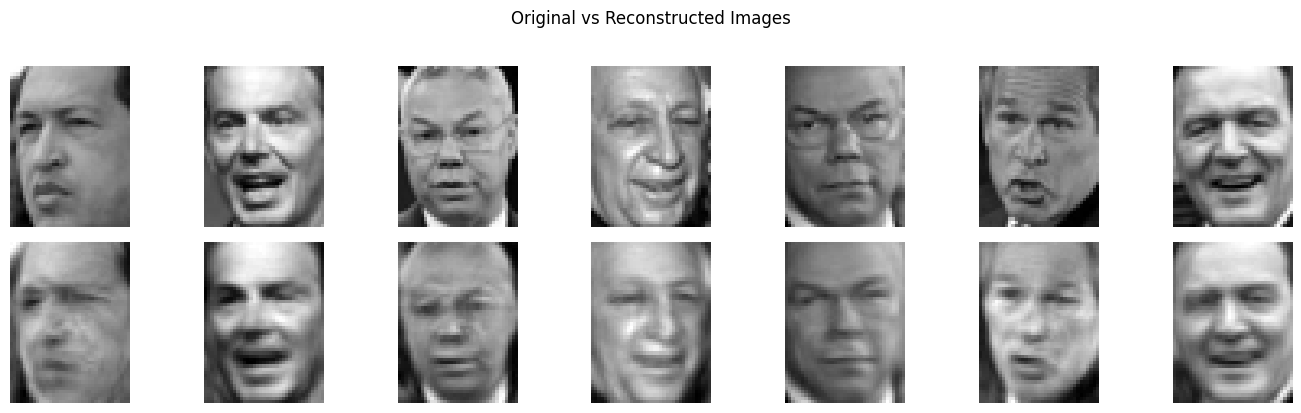

In [ ]:
plot_reconstructed_images(
    X, X_reconstructed,
    image_shape=(50, 37),
    indices=[0,1,3,4,5,6,7],
    n_cols=7
)